In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 102kB 6.3MB/s 
     |████████████████████████████████| 38.2MB 1.5MB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import seaborn as sns

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import init
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from PIL import Image

import time
import copy
import cv2
import albumentations
import sys

import sklearn.metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

# Helper Functions

### get_metadata

In [ ]:
def get_metadata(df_train, df_test):
    
    # One-hot encoding for anatom_site_general challenge feature
    concat = pd.concat([ df_train['anatom_site_general_challenge'], df_test['anatom_site_general_challenge'] ],
                      ignore_index=True)
    dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
    df_train = pd.concat([ df_train, dummies.iloc[:df_train.shape[0]] ], axis=1)
    df_test = pd.concat([ df_test, dummies.iloc[df_train.shape[0]:].reset_index(drop=True) ], axis=1)
    
    
    # Sex features
    df_train['sex'] = df_train['sex'].map({'male' : 1, 'female' : 0})
    df_train['sex'] = df_test['sex'].map({'male' : 1, 'female' : 0})

    df_train['sex'] = df_train['sex'].fillna(-1)  # NA/NaN 값을 -1로 채우기
    df_test['sex'] = df_test['sex'].fillna(-1)
    
    
    # Age features
    df_train['age_approx'] /= 90
    df_test['age_approx'] /= 90
    
    df_train['age_approx'] = df_train['age_approx'].fillna(0) # NA/NaN 값을 0으로 채움
    df_test['age_approx'] = df_test['age_approx'].fillna(0)
    
    df_train['patient_id'] = df_train['patient_id'].fillna(0)
    
    
    # n_image features
    df_train_patient = df_train.groupby(['patient_id'])
    df_train['n_images'] = df_train.patient_id.map(df_train_patient.image_name.count())
    df_test_patient = df_test.groupby(['patient_id'])
    df_test['n_images'] = df_test.patient_id.map(df_test_patient.image_name.count())
    
    df_train.loc[df_train['patient_id'] == -1, 'n_images'] = 1 
    
    df_train['n_images'] = np.log1p(df_train['n_images'].values)
    df_test['n_images'] = np.log1p(df_test['n_images'].values)
    
    
    # image size
    train_images = df_train['filepath'].values
    # print(train_images) 
    # ['bt_data\\jpeg-melanoma-512x512/train\\ISIC_2637011.jpg' ... ] 
    train_sizes = np.zeros(train_images.shape[0])
    # print(train_sizes) --> [0. 0. 0. ... ]
    
    for i, img_path in enumerate(tqdm(train_images)):
        train_sizes[i] = os.path.getsize(img_path)
        
    df_train['image_size'] = np.log(train_sizes)  # 로그범위에 두면, 더 정확한 결과
    
    test_images = df_test['filepath'].values
    test_sizes = np.zeros(test_images.shape[0])
    
    for i, img_path in enumerate(tqdm(test_images)):
        test_sizes[i] = os.path.getsize(img_path)
        
    df_test['image_size'] = np.log(test_sizes)
    
    
    
    meta_features = ['sex', 'age_approx', 'n_images', 'image_size'] + [col for col in df_train.columns if col.startswith('site_')]
    n_meta_features = len(meta_features)
    
    return df_train, df_test, meta_features, n_meta_features
    



### get_dataframe

In [ ]:
def get_df(use_meta):

    # Train data
    df_train = pd.read_csv('/content/drive/MyDrive/thesis/data/train.csv')
    
    targets = df_train.target.values

    df_train['filepath'] = df_train['image_name'].apply(lambda x: os.path.join('/content/drive/MyDrive/thesis/data/train', 
                                                                               f'{x}.jpg'))

    print(df_train.target.value_counts())
    df_train.to_csv("train_folds.csv", index=False)
    
    # Test Data
    df_test = pd.read_csv('/content/drive/MyDrive/thesis/data/test.csv')
    df_test['filepath'] = df_test['image_name'].apply(lambda x: os.path.join('/content/drive/MyDrive/thesis/data/test',
                                                                             f'{x}.jpg'))
    
    if use_meta:
        df_train, df_test, meta_features, n_meta_features = get_metadata(df_train, df_test)    
    else:
        meta_features = None
        n_meta_features = 0
    
    # df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('seborrheic keratosis', 'BKL'))
    # df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('lichenoid keratosis', 'BKL'))
    # df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('solar lentigo', 'BKL'))
    # df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('lentigo NOS', 'BKL'))
    # df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('cafe-au-lait macule', 'unknown'))
    # df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('atypical melanocytic proliferation', 'unknown'))
  
  # Class Mapping
    diagnosis_to_idx = { d: idx for idx, d in enumerate(sorted(df_train.diagnosis.unique())) }
    print(diagnosis_to_idx) 
    # --> {'BKL': 0, 'melanoma': 1, 'nevus': 2, 'unknown': 3}
    df_train['diagnosis_idx'] = df_train['diagnosis'].map(diagnosis_to_idx)
    # target 말고 new_diagnosis로 이름 변경하기
    melanoma_idx = diagnosis_to_idx['melanoma']
    
    # malignant_idx = df_train.benign_malignant['malignant']
        
    
    return df_train, targets, df_test, meta_features, n_meta_features, melanoma_idx
    

### MelanomaDataset

In [ ]:
class MelanomaDataset(Dataset):
    '''Melanoma Dataset'''

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.image_paths = self.df.filepath.values

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image = image.transpose(2, 0, 1)

        label = torch.tensor(self.df.target.values[index])

        return image, label

### AttConv

In [ ]:
class AttConv(nn.Module):
    def __init__(self, num_in_chan=1, num_out_chan=6, kernel_size=5, stride=1):
        super(AttConv, self).__init__()
        self.kernel_size=kernel_size
        self.num_in_chan=num_in_chan
        self.num_out_chan=num_out_chan
        self.stride=stride
        self.BU_weights = nn.Parameter(torch.HalfTensor(1,num_in_chan*kernel_size**2, 1, num_out_chan))
        init.kaiming_uniform_(self.BU_weights, a=np.sqrt(5))
        self.TD_weights = nn.Parameter(self.BU_weights.data.detach().clone())
        
        self.BU_bias = nn.Parameter(torch.randn(1,1,1,num_out_chan)*0.1)
        self.TD_bias = nn.Parameter(torch.randn(1,num_in_chan,1,1)*0.1)
        
    def normalize_att_weights(self, in_spat_dim):
        batch_size = self.att_weights.shape[0]        
        num_wins = self.att_weights.shape[-1]
        aw_sum = F.unfold(F.fold(self.att_weights, in_spat_dim, self.kernel_size,stride=self.stride), self.kernel_size, stride=self.stride) #Fold into image domain (which automatically computes the sum per pixel), and then unfold again into conv windows    
        self.att_weights = self.att_weights/aw_sum #Normalize weights by their sum over possible parents
        self.att_weights = self.att_weights.view(batch_size, 1, self.kernel_size**2, num_wins).expand(batch_size, self.num_in_chan, self.kernel_size**2, num_wins).reshape(batch_size, self.num_in_chan*self.kernel_size**2, num_wins)
        
        
    def forward(self, x, num_iter=4):
        batch_size = x.shape[0]
        device = x.device
        in_spat_dim = list(x.shape[-2:])                
        assert in_spat_dim[0]==in_spat_dim[1], 'Only square images are supported'
        x_wins = F.unfold(x.view(batch_size,self.num_in_chan,*in_spat_dim), self.kernel_size, stride=self.stride)
        x_wins = x_wins.type(torch.half)
        out_spat_dim = np.int(np.sqrt(x_wins.shape[-1]))
        self.att_weights = torch.ones([batch_size, self.kernel_size**2, x_wins.shape[-1]], device=device, dtype=torch.half)        
        self.normalize_att_weights(in_spat_dim)
        
        
        for i in range(num_iter):
            y = F.relu((x_wins.unsqueeze(-1)*self.att_weights.unsqueeze(-1)*self.BU_weights).sum(1,True) + self.BU_bias)
            pred = (y*self.TD_weights).sum(-1).view(batch_size,self.num_in_chan,self.kernel_size**2, -1) + self.TD_bias            
            self.att_weights = ((pred*x_wins.view(batch_size,self.num_in_chan,self.kernel_size**2, -1)).sum(1) / np.sqrt(self.num_in_chan)).exp()
            self.normalize_att_weights(in_spat_dim)   

        y = y.view(batch_size, out_spat_dim, out_spat_dim, self.num_out_chan).permute(0,3,1,2)
        
        return y

    
        

In [ ]:
plt.style.use(['classic'])
np.random.seed(13)
torch.manual_seed(13)

# Load Data

In [ ]:
df_train, targets, df_test, meta_features, n_meta_features, melanoma_idx = get_df(True)

0    32542
1      584
Name: target, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



{'atypical melanocytic proliferation': 0, 'cafe-au-lait macule': 1, 'lentigo NOS': 2, 'lichenoid keratosis': 3, 'melanoma': 4, 'nevus': 5, 'seborrheic keratosis': 6, 'solar lentigo': 7, 'unknown': 8}


In [ ]:
df_train

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,filepath,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_torso,site_upper extremity,site_nan,n_images,image_size,diagnosis_idx
0,ISIC_2637011,IP_7279968,1.0,0.500000,head/neck,unknown,benign,0,0,6000,4000,/content/drive/MyDrive/thesis/data/train/ISIC_...,1,0,0,0,0,0,0,4.753590,9.963783,8
1,ISIC_0015719,IP_3075186,1.0,0.500000,upper extremity,unknown,benign,0,0,6000,4000,/content/drive/MyDrive/thesis/data/train/ISIC_...,0,0,0,0,0,1,0,3.218876,10.020871,8
2,ISIC_0052212,IP_2842074,0.0,0.555556,lower extremity,nevus,benign,0,6,1872,1053,/content/drive/MyDrive/thesis/data/train/ISIC_...,0,1,0,0,0,0,0,1.791759,9.791829,5
3,ISIC_0068279,IP_6890425,0.0,0.500000,head/neck,unknown,benign,0,0,1872,1053,/content/drive/MyDrive/thesis/data/train/ISIC_...,1,0,0,0,0,0,0,3.135494,10.342226,8
4,ISIC_0074268,IP_8723313,0.0,0.611111,upper extremity,unknown,benign,0,11,6000,4000,/content/drive/MyDrive/thesis/data/train/ISIC_...,0,0,0,0,0,1,0,3.044522,9.928570,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,-1.0,0.555556,torso,unknown,benign,0,2,2592,1936,/content/drive/MyDrive/thesis/data/train/ISIC_...,0,0,0,0,1,0,0,3.610918,9.847235,8
33122,ISIC_9999320,IP_3650745,-1.0,0.722222,torso,unknown,benign,0,11,6000,4000,/content/drive/MyDrive/thesis/data/train/ISIC_...,0,0,0,0,1,0,0,3.526361,9.423999,8
33123,ISIC_9999515,IP_2026598,-1.0,0.222222,lower extremity,unknown,benign,0,3,1872,1053,/content/drive/MyDrive/thesis/data/train/ISIC_...,0,1,0,0,0,0,0,4.025352,9.668714,8
33124,ISIC_9999666,IP_7702038,-1.0,0.555556,lower extremity,unknown,benign,0,11,1872,1053,/content/drive/MyDrive/thesis/data/train/ISIC_...,0,1,0,0,0,0,0,3.401197,9.586651,8


In [ ]:
print('Metadata features:',meta_features)
print('The number of metadata features:',n_meta_features)
print('Index indicating Melanoma:',mel_idx)

Metadata features: ['sex', 'age_approx', 'n_images', 'image_size', 'site_head/neck', 'site_lower extremity', 'site_oral/genital', 'site_palms/soles', 'site_torso', 'site_upper extremity', 'site_nan']
The number of metadata features: 11
Index indicating Melanoma: 1


In [ ]:
print(df_train.head())
print('\n')

print(df_train.info())
print('\n')

     image_name  patient_id  sex  ...  n_images image_size diagnosis_idx
0  ISIC_2637011  IP_7279968  1.0  ...  4.753590   9.963783             8
1  ISIC_0015719  IP_3075186  1.0  ...  3.218876  10.020871             8
2  ISIC_0052212  IP_2842074  0.0  ...  1.791759   9.791829             5
3  ISIC_0068279  IP_6890425  0.0  ...  3.135494  10.342226             8
4  ISIC_0074268  IP_8723313  0.0  ...  3.044522   9.928570             8

[5 rows x 22 columns]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33126 non-null  float64
 3   age_approx                     33126 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   dia

benign       32542
malignant      584
Name: benign_malignant, dtype: int64


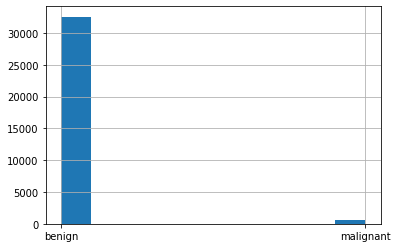

In [ ]:
print(df_train['benign_malignant'].value_counts())
df_train['benign_malignant'].hist()

unknown     27126
nevus        5193
melanoma      584
BKL           223
Name: diagnosis, dtype: int64


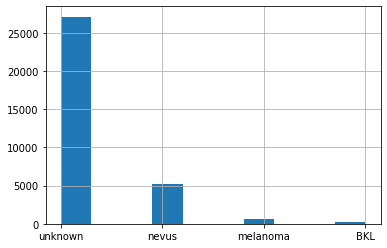

In [ ]:
print(df_train['diagnosis'].value_counts())
df_train['diagnosis'].hist()

In [ ]:
malignant_dataset = df_train.loc[df_train['benign_malignant'] == 'malignant']
benign_dataset = df_train.loc[df_train['benign_malignant'] == 'benign']

print(malignant_dataset.head(), len(malignant_dataset))
print(benign_dataset.head(), len(benign_dataset))

       image_name  patient_id  sex  ...  n_images image_size diagnosis_idx
91   ISIC_0149568  IP_0962375  1.0  ...  3.761200   9.923535             1
235  ISIC_0188432  IP_0135517  1.0  ...  2.772589  10.092454             1
314  ISIC_0207268  IP_7735373  0.0  ...  2.890372   9.948795             1
399  ISIC_0232101  IP_8349964  0.0  ...  3.465736   9.485621             1
459  ISIC_0247330  IP_3232631  1.0  ...  3.044522   9.960671             1

[5 rows x 22 columns] 584
     image_name  patient_id  sex  ...  n_images image_size diagnosis_idx
0  ISIC_2637011  IP_7279968  1.0  ...  4.753590   9.963783             3
1  ISIC_0015719  IP_3075186  1.0  ...  3.218876  10.020871             3
2  ISIC_0052212  IP_2842074  0.0  ...  1.791759   9.791829             2
3  ISIC_0068279  IP_6890425  0.0  ...  3.135494  10.342226             3
4  ISIC_0074268  IP_8723313  0.0  ...  3.044522   9.928570             3

[5 rows x 22 columns] 32542


-------------- Maglinant sample --------------


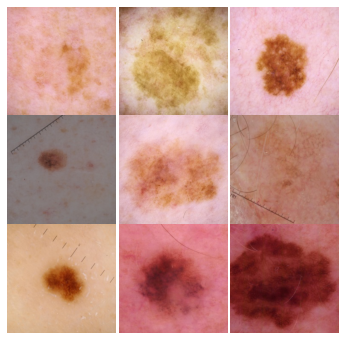

In [ ]:
print('-------------- Maglinant sample --------------')
malignants = df_train.loc[df_train['benign_malignant'] == 'malignant']['filepath'].values
# print(malignants[:9])

color = True

plt.rcParams['figure.figsize'] = (6.0, 6.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows, ncols = 3, 3

for i, id_ in enumerate(malignants[: nrows * ncols]):
    img = Image.open(id_)
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(np.array(img))
    plt.axis('off')

-------------- Benign sample --------------


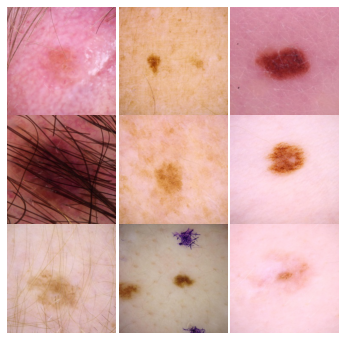

In [ ]:
print('-------------- Benign sample --------------')
benigns = df_train.loc[df_train['benign_malignant'] == 'benign']['filepath'].values
# print(benigns[:9])

color = True

plt.rcParams['figure.figsize'] = (6.0, 6.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows, ncols = 3, 3

for i, id_ in enumerate(benigns[: nrows * ncols]):
    img = Image.open(id_)
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(np.array(img))
    plt.axis('off')